<a href="https://colab.research.google.com/github/RPFey/Kaggle_Colab/blob/main/Kaggle_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 3 Homework


**Instructor:** Konrad Kording

**Content Creators:** Arash Ash, Jordan Lei

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()


---
# Setup

In [1]:
# imports
import os
import csv
import json
import random
import pathlib

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML, display

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cuda'), 2)

In [2]:
# @title Install Kaggle API (run me)
# %%capture
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.10
!kaggle -v

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=50669344e7f330de41510d74b1f156135cacc4b82e8cdbed66032522c631af66
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))

# Part 1. Kaggle Competition
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in Colab Files on the left menu.

Then join the competition and accept the rules at https://www.kaggle.com/c/permuted-animal-faces/rules.
Now we can handle the submisions here using the Kaggle API:

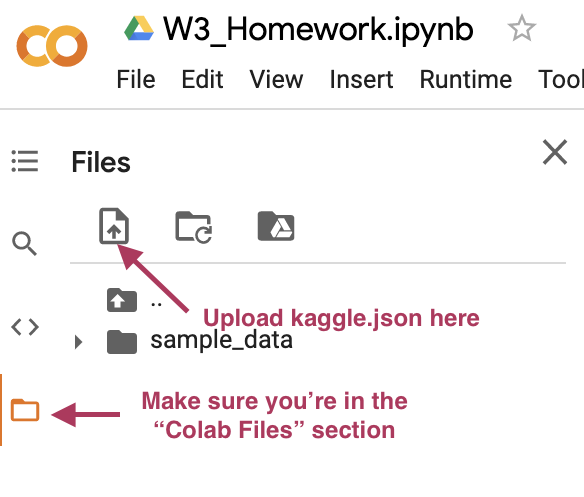

In [4]:
# registering your API key
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c permuted-animal-faces
!unzip permuted-animal-faces.zip

 83% 52.0M/62.8M [00:00<00:00, 102MB/s] 
100% 62.8M/62.8M [00:00<00:00, 116MB/s]
Archive:  permuted-animal-faces.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


Now it's your turn to train a competitive model using what you learned about MLPs and show it off to the rest of the world in the Kaggle leaderboard.

Here we provided you the same code as in the tutorial and the submission code, which you can run and get a baseline result. But we encourage you to get creative and combine your previous ML know-how since nothing is off the table in this competition.

In [7]:
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        exec('self.actv = nn.%s'%actv)   # [TO-DO]

        self.layers = nn.ModuleList()
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs)]   # [TO-DO]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # flattening
        x = x.view(x.shape[0], -1)   # [TO-DO]

        for layer in self.layers:
          x = self.actv(layer(x))
        x = self.dropout(x)  # [TO-DO]
        x = self.out(x) # [TO-DO]
        return x

In [8]:
df = pd.read_csv('train.csv')
df.head()

,Label,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,pixel 11,pixel 12,pixel 13,pixel 14,pixel 15,pixel 16,pixel 17,pixel 18,pixel 19,pixel 20,pixel 21,pixel 22,pixel 23,pixel 24,pixel 25,pixel 26,pixel 27,pixel 28,pixel 29,pixel 30,pixel 31,pixel 32,pixel 33,pixel 34,pixel 35,pixel 36,pixel 37,pixel 38,pixel 39,...,pixel 3033,pixel 3034,pixel 3035,pixel 3036,pixel 3037,pixel 3038,pixel 3039,pixel 3040,pixel 3041,pixel 3042,pixel 3043,pixel 3044,pixel 3045,pixel 3046,pixel 3047,pixel 3048,pixel 3049,pixel 3050,pixel 3051,pixel 3052,pixel 3053,pixel 3054,pixel 3055,pixel 3056,pixel 3057,pixel 3058,pixel 3059,pixel 3060,pixel 3061,pixel 3062,pixel 3063,pixel 3064,pixel 3065,pixel 3066,pixel 3067,pixel 3068,pixel 3069,pixel 3070,pixel 3071,pixel 3072
0,2,162,105,32,160,83,123,146,138,74,59,126,68,0,82,96,77,188,61,58,134,63,222,152,128,114,74,193,55,82,84,130,111,109,41,75,160,203,158,49,...,89,109,186,122,197,107,168,131,91,103,59,130,62,106,128,164,74,58,114,152,82,180,177,111,30,155,145,64,173,130,78,170,150,56,144,94,54,103,157,110
1,0,72,199,23,46,121,36,116,244,50,245,106,225,83,199,98,161,37,12,51,144,232,81,58,99,236,211,119,100,240,128,28,37,117,135,232,156,58,126,60,...,165,132,51,163,30,101,123,31,50,21,241,36,55,179,104,84,225,237,152,37,160,98,156,170,104,74,48,41,39,174,196,154,157,240,78,67,161,163,163,139
2,2,60,255,33,45,59,72,82,75,116,83,128,250,13,255,35,253,213,60,75,71,255,128,43,78,253,251,111,78,124,43,72,105,131,16,253,223,0,88,35,...,166,0,53,0,110,42,169,25,89,39,0,113,76,202,0,82,253,0,128,90,180,121,255,255,104,135,241,56,104,255,255,86,235,149,63,21,253,86,255,191
3,0,185,198,23,148,174,59,114,207,165,218,224,187,161,214,176,212,153,134,98,94,230,133,137,85,206,200,111,154,210,152,96,175,230,142,177,218,0,143,52,...,169,0,108,0,189,108,202,138,151,91,0,103,121,210,0,176,177,0,232,87,215,206,203,224,188,117,194,63,111,223,227,78,230,199,117,200,211,206,219,150
4,2,176,54,96,131,80,210,177,87,158,45,169,94,116,58,114,75,75,67,154,187,66,116,107,165,69,64,188,110,69,133,126,74,168,56,49,89,179,105,118,...,179,55,173,67,41,137,84,196,87,122,64,173,146,168,75,110,103,72,183,184,65,133,62,87,57,135,59,179,171,116,57,103,75,175,162,135,75,65,78,147


In [9]:
data = np.array(df)
X_train = torch.tensor(data[:, 1:]).float()/255
y_train = torch.tensor(data[:, 0]).long()

In [10]:
batch_size = 128
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=10)

In [11]:
def train_test_classification(net, criterion, optimizer,
                              train_loader,
                              num_epochs=1, verbose=True,
                              training_plot=True):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  net.train()
  training_losses = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).long()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0

  net.eval()
  def test(data_loader):
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(dev).float()
        labels = labels.to(dev).long()

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()
  
  return train_acc

Accuracy on the 14592 training samples: 92.59 %


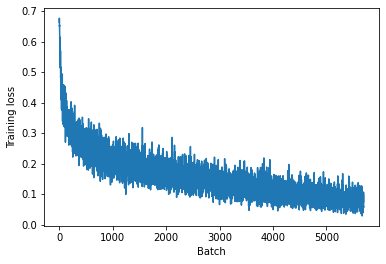

In [12]:
net = Net('ReLU()', 3*32*32, [128, 32], 3).to(dev) 
criterion = nn.MultiMarginLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=3e-4)
train_acc = train_test_classification(net, criterion, optimizer,
                                      train_loader,
                                      num_epochs=50)

In [13]:
# Predict test set
df = pd.read_csv('test.csv')
data = np.array(df)
X_test = torch.tensor(data).float()/255

net.eval()
y_pred = net(X_test.to(dev))
labels_pred = torch.argmax(y_pred, dim=1)

In [14]:
# create the submission file
header = ['ImageId', 'Label']
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for i in range(len(labels_pred)):
      writer.writerow([i+1] + [labels_pred[i].item()])

In [ ]:
# submit
!kaggle competitions submit permuted-animal-faces -f submission.csv -m "Result with same model as in the tutorial"

Note that you can submit maximum 20 times a day. Participants will need to wait until the next UTC day after submitting the maximum number of daily submissions.

And finally you can hand select 2 submissions among your previous ones to be used for the final ranking.

# Part 2. Deep Learning, Deeper Thinking



## 2.1 Our Data-Processing Wish List

By now you should be pretty familiar with classifying animal faces using multi-layer perceptrons. MLPs make very few assumptions about the underlying structure of the data, which make them very flexible in approximating a wide variety of functions. However, sometimes it can be helpful to constrain the set of possible functions we want to approximate by introducing some "rules" that these functions need to follow. We call these rules **inductive biases**. 

For example, one inductive bias might be the rule that "A cat is a cat, no matter where it is placed in the image. An upper-left-corner cat is just as much of a cat as a lower-right-corner cat." That describes an inductive bias called **translational invariance**, which basically says that the class of an object is invariant to translation (it doesn't matter where it is, as long as it's there). If we could have a model that preserves translational invariance, chances are it would be helpful in finding us good models for image processing (more on this later). 

**Now that you're familiar with the concept of inductive biases, please do the following:**
* List one inductive bias other than translational invariance that would be good to have for image processing
* Suppose you're trying to develop a model to assign credit scores to people based on their personal data. What kind of inductive biases or data guarantees would you want to impose on this system?

In [ ]:
#Delete the starter text, enter your response, and run the cell.
q_2_1 = '''
Your Response to Q 2.1 Here

'''

## 2.2 The Ethics of Facial Recognition
In part 1, we just had you create a network that was good at classifying faces of animals. What happens when this technologies are used on humans? What happens when these technologies are used by law enforcement? In this section, we'll explore these implications. So play your favorite Lo-Fi Beats to Study/Relax To and let's get started!


### 2.2.1 **America Under Watch**
As data scientists, we often complain that we don't have enough data. Sometimes lack of good data isn't the problem. What happens if we collect data *everywhere*? In many countries around the world, facial recognition is used by law enforcement to conduct wide-scale law enforcement. Thankfully that's not the case in the United States. Right? 

*... Right?* 

Read the following:

* https://www.americaunderwatch.com/

**In 200-300 words, please answer the following questions.** 
* In America Under Watch, the Georgetown Law Center proposes a moratorium (temporary freeze) on the police use of facial recognition. Do you agree or disagree with this choice, and why? 
* The article mentions the fact that *facial surveillance is disproportionately likely to impact communities of color and communities with lower socio-economic status (SES)*. Think about what this means about what amount + what kinds of data law enforcement collect on people of color. How might this perpetuate cycles of incarceration for people of color in the U.S.?
* If facial recognition were to be put in place in a highly secure location, like the White House, what kind of inductive biases would you want to ensure that such a system would have? What guarantees might you want to have about the data that is used to train the network, the data that is collected, and what is done with the data afterward? 



In [ ]:
#Delete the starter text, enter your response, and run the cell.
q_2_2_1 = '''
Your Response to Q 2.2.1 Here (200 - 300 words)

'''

### 2.2.2 **Grab Some Popcorn**


In [ ]:
#@markdown That's enough reading for today, don't you think? Grab some popcorn, run this cell, and watch this video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="jZjmlJPJgug", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

**In 200-300 words, please answer the following questions**
* In the segment, John Oliver mentions that Clearview AI uses "publicly available data", which includes public profile information on Facebook, LinkedIn, Twitter, and Instagram. Clearview argues that this information has all been willingly made public. Do you agree? Why or why not?
* Some prominent data scientists claim that "data/algorithms don't have bias, people have bias". Do you agree with this sentiment? Why or why not?


In [ ]:
#Delete the starter text, enter your response, and run the cell.
q_2_2_2 = '''
Your Response to Q 2.2.2 Here (200 - 300 words)

'''

# Submit to Airtable
**Don't forget to contribute to the conversation in your pod slack channel.** You can do so by copying and pasting some or all of the answers to the above questions, or by commenting and responding to other people's posts.


In [ ]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: q_2_1;
except NameError: q_2_1 = ""
try: q_2_2_1;
except NameError: q_2_2_1 = ""
try: q_2_2_2;
except NameError: q_2_2_2 = ""


times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "q_2_1": q_2_1,
          "q_2_2_1": q_2_2_1,
          "q_2_2_2": q_2_2_2,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrzuKoahe4ZQKvND?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))